In [1]:
import sys

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import datetime as dt
import xgboost 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from category_encoders import LeaveOneOutEncoder
pandas2ri.activate()

In [3]:
%matplotlib inline
pd.set_option('display.max_columns', 500)

# 1. Summary

In this notebook I analyze the impressions of a mobile campaign. The goal is to predict the occurrence of a click and a conversion, given all the features of an impression.

Initially I explore the given features and the target variables click and conversion. Both click and conversion have unbalanced classes, hence I use AUC as a performance metric for the classification problem. 

Exploring the features shows that some of the variables are not useful for modeling, due to them having the same value for all data samples (e.g. OS, deviceReferrer). This is also the case for many other features such as the *exelate* user interest variables; 25 more variables are dropped from the dataset.

An important part of every data science problem solving is feature engineering. I extract the boolean feature **landscape_mode** from the browser width and height (takes the value 1 when width > height, and 0 otherwise). This feature does a really good job at differentiating impressions with a click from the ones without a click. The $\chi^2$ test results in a significant test statistic; the impressions in landscape mode have a higher Click Rate than the impressions in portrait mode.

In addition, I use Leave One Out Envoding for categorical features. E.g. for the browser language feature, this encoder computes the average click rate for every language (it also excludes the current sample from the computation and adds random noise). Initially I did not encode the feature **adSpaceId**. After encoding, this feature became one of the most important ones for the XGBoost model.

After EDA and data processing, I built an XGBoost model with click as a target variable and the Area Under Curve of the test set as the evaluation metric. The performance is relatively poor with an AUC of around 0.67.

These are some of the most important features for predicting clicks:

- Device Height
- Device Width
- Landscape Mode
- Ad Space ID
- Last 7 days clicks on format
- Last 30 min closings on container

Ideas for improving the click prediction model:
- More detailed analysis of the features with integer data type (e.g. *exalate* variables seem to only get a few distinct values and it might be better to treat them as categorical features instead of numeric ones)
- Extract features from the timestamp of the impression (e.g. if it's during business working hours, in the evening etc.)
- Feature selection (either using a model with an L1 penalty like Lasso or by making use of knowledge of the ad context. E.g. if a fashion product is being advertised some user interest features such as real estate might be useless)
- Tuning XGBoost parameters using grid search or Bayesian Optimisation (e.g. max_depth, min_child_weight and gamma can be used to control model complexity and prevent overfitting).


Predicting conversions is of course more challenging, with the AUC being lower than for the click prediction model. Here I observer an overfitting problem with the training set AUC being much higher than the test set one. Additional measures are necessary for preventing this such as controling the tree complexity parameters (max_depth, min_child_weight, colsample_bytree or gamma). 



# 2. Exploratory Data Analysis

The dataset contains 962K impressions and 135 columns. Most of the features are of integer type (106 of them), 23 are float and 6 categorical. A more in-depth analysis is needed to decide whether the integer features should be considered as numeric or categorical ones.

## 2.1. Target Variable Analysis

9.8% of the impressions lead to clicks while only 0.043% of them result in a conversion. This shows that we are dealing with an unbalanced class classification problem, particularly in the case of conversion. Therefore, we shouldn't rely on accuracy as a performance metric but a combination of precision and recall e.g. F1 or AUC.

In [4]:
%%time
df = pd.read_csv("campaign.csv")

CPU times: user 8.36 s, sys: 1.96 s, total: 10.3 s
Wall time: 10.3 s


In [5]:
df.head(n=10)

,timestamp,admantx_art_and_entertainment,admantx_automotive,admantx_business,admantx_careers,admantx_education,admantx_family_and_parenting,admantx_health_and_fitness,admantx_food_and_drink,admantx_hobbies_and_interests,admantx_home_and_garden,admantx_law_govt_and_politics,admantx_news,admantx_finance,admantx_society,admantx_science,admantx_pets,admantx_sports,admantx_style_and_fashion,admantx_technology_and_computing,admantx_travel,admantx_real_estate,admantx_shopping,admantx_religion_and_spirituality,browserHeight,browserWidth,deviceHeight,deviceWidth,documentHeight,documentWidth,exelate_auto_buyers,exelate_auto_owners,exelate_beauty_and_style,exelate_business,exelate_charitable_donors,exelate_cpg,exelate_diet_and_fitness,exelate_entertainment,exelate_events,exelate_finance,exelate_finance_and_insurance,exelate_general_interest,exelate_hobbies,exelate_home_improvement,exelate_internet_connection_type,exelate_language,exelate_parenting,exelate_pets,exelate_propensity,exelate_purchase_behaviors,exelate_seasonal,exelate_services,exelate_shopping,exelate_sports,exelate_tech_enthusiasts,exelate_tickets,exelate_travel,exelate_tv_viewership,last24hClicks,last24hClicksOnAdvertiser,last24hClicksOnContainer,last24hClicksOnFormat,last24hIframeClosings,last24hIframeClosingsOnAdvertiser,last24hIframeClosingsOnContainer,last24hIframeClosingsOnFormat,last24hImpressions,last24hImpressionsOnAdvertiser,last24hImpressionsOnContainer,last24hImpressionsOnFormat,last24hAdClosings,last24hAdClosingsOnAdvertiser,last24hAdClosingsOnContainer,last24hAdClosingsOnFormat,last30minClicks,last30minClicksOnAdvertiser,last30minClicksOnContainer,last30minClicksOnFormat,last30minIframeClosings,last30minIframeClosingsOnAdvertiser,last30minIframeClosingsOnContainer,last30minIframeClosingsOnFormat,last30minImpressions,last30minImpressionsOnAdvertiser,last30minImpressionsOnContainer,last30minImpressionsOnFormat,last30minAdClosings,last30minAdClosingsOnAdvertiser,last30minAdClosingsOnContainer,last30minAdClosingsOnFormat,last7dClicks,last7dClicksOnAdvertiser,last7dClicksOnContainer,last7dClicksOnFormat,last7dIframeClosings,last7dIframeClosingsOnAdvertiser,last7dIframeClosingsOnContainer,last7dIframeClosingsOnFormat,last7dImpressions,last7dImpressionsOnAdvertiser,last7dImpressionsOnContainer,last7dImpressionsOnFormat,last7dAdClosings,last7dAdClosingsOnAdvertiser,last7dAdClosingsOnContainer,last7dAdClosingsOnFormat,last30dClicks,last30dClicksOnAdvertiser,last30dClicksOnContainer,last30dClicksOnFormat,last30dIframeClosings,last30dIframeClosingsOnAdvertiser,last30dIframeClosingsOnContainer,last30dIframeClosingsOnFormat,last30dImpressions,last30dImpressionsOnAdvertiser,last30dImpressionsOnContainer,last30dImpressionsOnFormat,last30dAdClosings,last30dAdClosingsOnAdvertiser,last30dAdClosingsOnContainer,last30dAdClosingsOnFormat,adSpaceId,browserLangage,browserName,os,city,adSpacePrimaryThematic,deviceReferrer,formatId,containerId,advertiserId,creativeId,click,conversion
0,1493337601,41.837,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.00,0.0,0.000,0.0,58.163,0.0,0.0,0.0,0.0,559,375,667,375,6342,375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1170,fr,Facebook,iOS,Bourg-les-valence,ART_AND_ENTERTAINMENT,other,111,8338,310,24595,0,0
1,1493337602,14.431,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,29.98,0.0,0.0,3.963,16.26,0.0,35.366,0.0,0.000,0.0,0.0,0.0,0.0,460,320,568,320,7090,320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,616,fr,Mobile Safari,iOS,Joeuf,NEWS,other,111,8338,310,24595,0,0
2,1493337615,63.729,0.0,0.0,0.0,0.0,5.109,0.0,0.0,0.0,0.0,0.00,0.0,0.0,7.407,0.00,0.0,18.391,0.0,5.364,0.0,0.0,0.0,0.0,645,375,667,375,7921,375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962973 entries, 0 to 962972
Columns: 135 entries, timestamp to conversion
dtypes: float64(23), int64(106), object(6)
memory usage: 991.8+ MB


In [7]:
df.click.describe()

count    962973.000000
mean          0.098368
std           0.297812
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: click, dtype: float64

In [8]:
df.click.value_counts()

0    868247
1     94726
Name: click, dtype: int64

In [9]:
df.conversion.describe()

count    962973.000000
mean          0.000433
std           0.020805
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: conversion, dtype: float64

In [10]:
df.conversion.value_counts()

0    962556
1       417
Name: conversion, dtype: int64

Let's split the dataset into a training and test set.

In [11]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
df_test.shape[0] + df_train.shape[0] == df.shape[0]

True

## 2.2. Feature Analysis

### Categorical Features

In [13]:
df.select_dtypes(object).columns

Index(['browserLangage', 'browserName', 'os', 'city', 'adSpacePrimaryThematic',
       'deviceReferrer'],
      dtype='object')

The dominating browser language is French, not surprising for a company founded in France. Fr doesn't dominate in terms of CTR though.

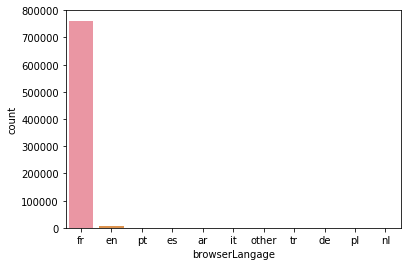

In [14]:
sns.countplot(x='browserLangage', data=df_train)

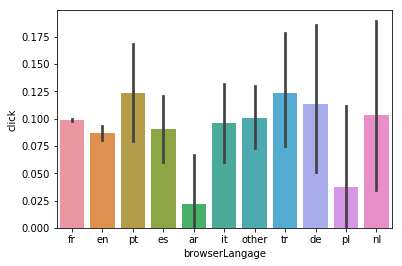

In [15]:
sns.barplot(x = 'browserLangage', y = 'click', data = df_train, estimator = np.mean)

FB dominates the number of impressions, and leads to a slightly higher CTR than Safari.

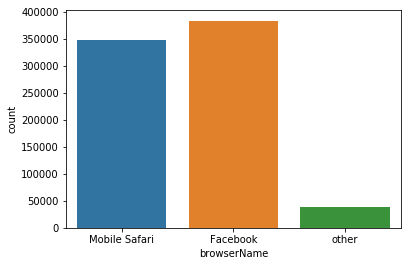

In [16]:
sns.countplot(x='browserName', data=df_train)

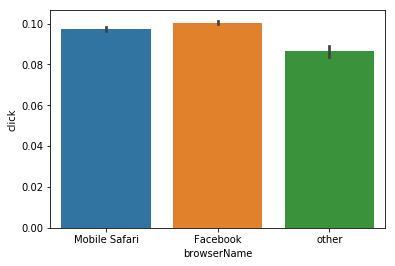

In [17]:
sns.barplot(x = 'browserName', y = 'click', data = df_train, estimator = np.mean)

There are more than 5000 unique cities. Encoding this categorical features with One Hot Encoding would lead to an explosion in dimensionality. I will use Leave One Out Encoding instead. 

In [18]:
df_train.city.nunique()

5215

In [19]:
df_train.adSpacePrimaryThematic.nunique()

18

There's just one device referrer and OS, therefore these feature should be dropped.

In [20]:
df_train.deviceReferrer.nunique()

1

In [21]:
df_train.os.nunique()

1

In [22]:
df_train = df_train.drop(['deviceReferrer', 'os'], axis=1)
df_test =df_test.drop(['deviceReferrer', 'os'], axis=1)

### Numeric Features

In [23]:
df_train.select_dtypes(float).columns

Index(['admantx_art_and_entertainment', 'admantx_automotive',
       'admantx_business', 'admantx_careers', 'admantx_education',
       'admantx_family_and_parenting', 'admantx_health_and_fitness',
       'admantx_food_and_drink', 'admantx_hobbies_and_interests',
       'admantx_home_and_garden', 'admantx_law_govt_and_politics',
       'admantx_news', 'admantx_finance', 'admantx_society', 'admantx_science',
       'admantx_pets', 'admantx_sports', 'admantx_style_and_fashion',
       'admantx_technology_and_computing', 'admantx_travel',
       'admantx_real_estate', 'admantx_shopping',
       'admantx_religion_and_spirituality'],
      dtype='object')

In [24]:
df_train.select_dtypes(int).columns

Index(['timestamp', 'browserHeight', 'browserWidth', 'deviceHeight',
       'deviceWidth', 'documentHeight', 'documentWidth', 'exelate_auto_buyers',
       'exelate_auto_owners', 'exelate_beauty_and_style',
       ...
       'last30dAdClosingsOnAdvertiser', 'last30dAdClosingsOnContainer',
       'last30dAdClosingsOnFormat', 'adSpaceId', 'formatId', 'containerId',
       'advertiserId', 'creativeId', 'click', 'conversion'],
      dtype='object', length=106)

#### Browser Width and Height can be used to capture whether the device is in landscape mode (width > height). This is the case for almost 0.2% of the impressions

In [25]:
stats.describe(df_train.browserWidth - df_train.browserHeight)

DescribeResult(nobs=770378, minmax=(-782, 1133), mean=-205.47192676841757, variance=3405.949592680235, skewness=1.430363916715722, kurtosis=13.266263473981653)

In [26]:
sum((df_train.browserWidth - df_train.browserHeight) > 0)/df_train.shape[0]

0.0018770006412436493

In [27]:
df_train['landscape_mode'] = np.where((df_train.browserWidth - df_train.browserHeight) > 0, 1, 0)
df_test['landscape_mode'] = np.where((df_test.browserWidth - df_test.browserHeight) > 0, 1, 0)

This plot indicates that this feature is quite important.

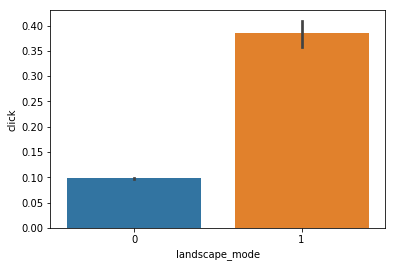

In [28]:
sns.barplot(x = 'landscape_mode', y = 'click', data = df_train, estimator = np.mean)

In [30]:
r_stats = importr('stats')
base = importr('base')
print(base.table(df_train['click'], df_train['landscape_mode'], 
                 dnn=['click', 'landscape_mode']))

     landscape_mode
click      0      1
    0 693691    890
    1  75241    556



The Chi Squared test indicates that the difference in CTR is indeed significant depending on whether the device is in landscape mode or not.

In [31]:
(r_stats.chisq_test(base.table(df_train['click'], df_train['landscape_mode'], 
                                    dnn=['click', 'landscape_mode'])))

R object with classes: ('htest',) mapped to:
<ListVector - Python:0x7f8ce18322c8 / R:0x3d84ebc8>
[FloatVector, IntVector, FloatVector, StrVector, ..., Matrix, Matrix, Matrix, Matrix]
  statistic: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f8ce1832288 / R:0x81efe28>
[1333.711880]
  parameter: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7f8ce1b197c8 / R:0x81efe58>
[1]
  p.value: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f8ce1907848 / R:0x81efdf8>
[0.000000]
  method: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f8ce1832308 / R:0x81efca8>
["Pearson's Chi-squared test with Yates' continuit...]
  data.name: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f8ce1918dc8 / R:0x3dc3f0c8>
['structure(c(6..., '    click = c..., '"landscape_mo...]
  observed: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('table',) mapped to:
<Matrix - Python:0x7f8ce1918b08 / R:0x3dc780c0>
[  693691,    75241,      890,      556]
  expected: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f8ce12a67c8 / R:0x3da869f0>
[693277.271018, 75654.728982, 1303.728982, 142.271018]
  residuals: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('table',) mapped to:
<Matrix - Python:0x7f8ce1b197c8 / R:0x3d992060>
[0.496893, -1.504173, -11.458355, 34.686280]
  stdres: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('table',) mapped to:
<Matrix - Python:0x7f8ce1907848 / R:0x3d9922e8>
[36.564209, -36.564209, -36.564209, 36.564209]

#### Finding columns with just 1 unique value and drop them for modeling purposes

In [34]:
%%time
nunique_values = df_train.select_dtypes(int).apply(lambda x: x.nunique(), axis=0)

CPU times: user 588 ms, sys: 328 ms, total: 916 ms
Wall time: 908 ms


In [35]:
drop_cols = list(nunique_values[nunique_values==1].index)
drop_cols

['exelate_auto_owners',
 'exelate_business',
 'exelate_charitable_donors',
 'exelate_diet_and_fitness',
 'exelate_events',
 'exelate_internet_connection_type',
 'exelate_language',
 'exelate_pets',
 'exelate_propensity',
 'exelate_seasonal',
 'exelate_services',
 'exelate_tickets',
 'exelate_tv_viewership',
 'last24hIframeClosingsOnAdvertiser',
 'last24hIframeClosingsOnContainer',
 'last24hIframeClosingsOnFormat',
 'last30minIframeClosingsOnAdvertiser',
 'last30minIframeClosingsOnContainer',
 'last30minIframeClosingsOnFormat',
 'last7dIframeClosingsOnAdvertiser',
 'last7dIframeClosingsOnContainer',
 'last7dIframeClosingsOnFormat',
 'last30dIframeClosingsOnAdvertiser',
 'last30dIframeClosingsOnContainer',
 'last30dIframeClosingsOnFormat',
 'formatId',
 'containerId',
 'advertiserId',
 'creativeId']

Number of columns after dropping

In [36]:
df_train.shape

(770378, 134)

In [37]:
df_train = df_train.drop(drop_cols, axis=1)
df_train.shape

(770378, 105)

In [38]:
df_test.shape

(192595, 134)

In [39]:
df_test = df_test.drop(drop_cols, axis=1)
df_test.shape

(192595, 105)

# 3. Data Wrangling

## 3.1. Encoding Categorical Features

Machine Learning models often require the data to be in numeric format. For this reason, I will encode the categorical features using Leave One Out Encoding.

In [40]:
df_train.select_dtypes(object).columns

Index(['browserLangage', 'browserName', 'city', 'adSpacePrimaryThematic'], dtype='object')

City won't be encoded because it takes too long due to the there being more than 5000 cities in the dataset.
AdSpaceId is of integer type but it's actually a categorical variable and should also be encoded.

In [41]:
%%time
categorical_features = ['browserLangage', 'browserName', 'adSpacePrimaryThematic', 'adSpaceId']
enc = LeaveOneOutEncoder(cols=categorical_features).fit(df_train, df_train['click'])
df_train = enc.transform(df_train)
df_test = enc.transform(df_test)

CPU times: user 10.3 s, sys: 11 s, total: 21.2 s
Wall time: 21.2 s


In [42]:
df_train.head()

,timestamp,admantx_art_and_entertainment,admantx_automotive,admantx_business,admantx_careers,admantx_education,admantx_family_and_parenting,admantx_health_and_fitness,admantx_food_and_drink,admantx_hobbies_and_interests,admantx_home_and_garden,admantx_law_govt_and_politics,admantx_news,admantx_finance,admantx_society,admantx_science,admantx_pets,admantx_sports,admantx_style_and_fashion,admantx_technology_and_computing,admantx_travel,admantx_real_estate,admantx_shopping,admantx_religion_and_spirituality,browserHeight,browserWidth,deviceHeight,deviceWidth,documentHeight,documentWidth,exelate_auto_buyers,exelate_beauty_and_style,exelate_cpg,exelate_entertainment,exelate_finance,exelate_finance_and_insurance,exelate_general_interest,exelate_hobbies,exelate_home_improvement,exelate_parenting,exelate_purchase_behaviors,exelate_shopping,exelate_sports,exelate_tech_enthusiasts,exelate_travel,last24hClicks,last24hClicksOnAdvertiser,last24hClicksOnContainer,last24hClicksOnFormat,last24hIframeClosings,last24hImpressions,last24hImpressionsOnAdvertiser,last24hImpressionsOnContainer,last24hImpressionsOnFormat,last24hAdClosings,last24hAdClosingsOnAdvertiser,last24hAdClosingsOnContainer,last24hAdClosingsOnFormat,last30minClicks,last30minClicksOnAdvertiser,last30minClicksOnContainer,last30minClicksOnFormat,last30minIframeClosings,last30minImpressions,last30minImpressionsOnAdvertiser,last30minImpressionsOnContainer,last30minImpressionsOnFormat,last30minAdClosings,last30minAdClosingsOnAdvertiser,last30minAdClosingsOnContainer,last30minAdClosingsOnFormat,last7dClicks,last7dClicksOnAdvertiser,last7dClicksOnContainer,last7dClicksOnFormat,last7dIframeClosings,last7dImpressions,last7dImpressionsOnAdvertiser,last7dImpressionsOnContainer,last7dImpressionsOnFormat,last7dAdClosings,last7dAdClosingsOnAdvertiser,last7dAdClosingsOnContainer,last7dAdClosingsOnFormat,last30dClicks,last30dClicksOnAdvertiser,last30dClicksOnContainer,last30dClicksOnFormat,last30dIframeClosings,last30dImpressions,last30dImpressionsOnAdvertiser,last30dImpressionsOnContainer,last30dImpressionsOnFormat,last30dAdClosings,last30dAdClosingsOnAdvertiser,last30dAdClosingsOnContainer,last30dAdClosingsOnFormat,city,click,conversion,landscape_mode,browserLangage,browserName,adSpacePrimaryThematic,adSpaceId
262224,1493380028,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.49,0.0,0.0,50.51,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,628,375,667,375,1542,375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Paris,0,0,0,0.098493,0.097392,0.090675,0.076523
53944,1493363881,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,605,375,667,375,7782,375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Villeurbanne,0,0,0,0.098493,0.100527,0.074297,0.063416
919859,1493419347,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,376,320,568,320,6795,320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Pantin,0,0,0,0.098493,0.097392,0.090675,0.097837
177211,1493370605,10.067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,89.933,0.0,0.0,0.0,0.0,0.0,0.0,460,320,568,320,4284,320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,La fare-les-oliviers,0,0,0,0.098493,0.097392,0.123015,0.051158
590084,1493398171,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,529,320,568,320,3415,320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Illies,0,0,0,0.098493,0.097392,0.079530,0.074723


## 3.2 Imputing Missing Values

There are actually no missing values in the dataset

In [44]:
df.isnull().sum().describe()

count    135.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

# 4. Model Building - Click Prediction

In [45]:
X_train = df_train.drop(['city', 'timestamp', 'click', 'conversion'], axis=1)
y_train = df_train['click']

X_test = df_test.drop(['city', 'timestamp', 'click', 'conversion'], axis=1)
y_test = df_test['click']

In [46]:
X_train.shape

(770378, 101)

The distribution of the target variable should be similar in the training and test set.

In [47]:
stats.describe(y_train)

DescribeResult(nobs=770378, minmax=(0, 1), mean=0.09838936210535607, variance=0.08870901067983641, skewness=2.696817871441506, kurtosis=5.272826631726295)

In [48]:
stats.describe(y_test)

DescribeResult(nobs=192595, minmax=(0, 1), mean=0.09828396375814533, variance=0.08862468638702173, skewness=2.6988138876222676, kurtosis=5.283596400022811)

## XGBoost

One of the most important parameters of XGBoost is the learning rate (eta) and colsample_bytree which is the percentag of features that is used for building each XGBoost tree.

In [51]:
dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)
%time
param = {'eta': 0.4, 'colsample_bytree': 0.7, 
         'objective': 'binary:logistic', 'early_stopping_rounds':30}
param['nthread'] = 25
param['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 200
bst = xgboost.train(param.items(), dtrain, num_round, evallist)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.4 µs
[0]	eval-auc:0.661691	train-auc:0.662551
[1]	eval-auc:0.663166	train-auc:0.664723
[2]	eval-auc:0.664741	train-auc:0.664586
[3]	eval-auc:0.665566	train-auc:0.666451
[4]	eval-auc:0.665955	train-auc:0.667584
[5]	eval-auc:0.665897	train-auc:0.667717
[6]	eval-auc:0.666495	train-auc:0.668927
[7]	eval-auc:0.667185	train-auc:0.669831
[8]	eval-auc:0.667311	train-auc:0.67062
[9]	eval-auc:0.667708	train-auc:0.671547
[10]	eval-auc:0.668206	train-auc:0.672894
[11]	eval-auc:0.668273	train-auc:0.673431
[12]	eval-auc:0.668591	train-auc:0.674511
[13]	eval-auc:0.668773	train-auc:0.675267
[14]	eval-auc:0.668812	train-auc:0.675768
[15]	eval-auc:0.669122	train-auc:0.676386
[16]	eval-auc:0.669153	train-auc:0.676778
[17]	eval-auc:0.669564	train-auc:0.677536
[18]	eval-auc:0.669666	train-auc:0.677912
[19]	eval-auc:0.669916	train-auc:0.678442
[20]	eval-auc:0.669982	train-auc:0.678999
[21]	eval-auc:0.670052	train-auc:0.679704
[22]	eval-auc:0.67011	t

[193]	eval-auc:0.674304	train-auc:0.7159
[194]	eval-auc:0.674376	train-auc:0.716187
[195]	eval-auc:0.674394	train-auc:0.716334
[196]	eval-auc:0.674532	train-auc:0.71678
[197]	eval-auc:0.674494	train-auc:0.716959
[198]	eval-auc:0.67459	train-auc:0.717156
[199]	eval-auc:0.674611	train-auc:0.717269


In [52]:
y_hat =  bst.predict(dtest)
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
auc = roc_auc_score(y_test, y_hat)
print('AUC: %f' %auc)

AUC: 0.674611


Text(0.5,0,'False Positive Rate')

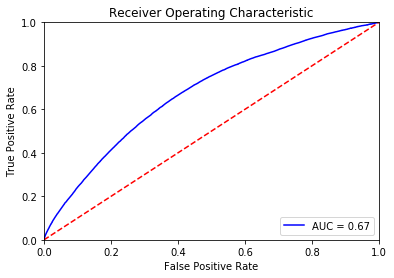

In [53]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Feature Importance

The most important feature is device height and width, followed by the engineered feature **landscape_mode**.
The categorical feature **adSpaceId** which was encoded using Leave One Out Encoding is also an important feature.

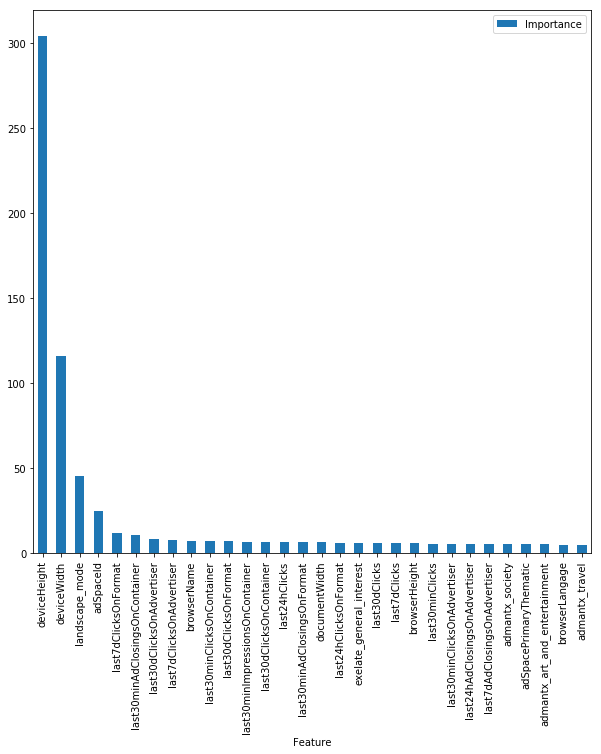

In [54]:
importances = bst.get_score(importance_type='gain')
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame = importance_frame.sort_values(by = 'Importance', ascending=False).head(30)
importance_frame.plot(kind = 'bar', x = 'Feature', figsize = (10, 10))

# Model Building - Conversion Prediction

In [55]:
y_train_conversion = df_train['conversion']
y_test_conversion = df_test['conversion']

In [73]:
dtrain_conversion = xgboost.DMatrix(X_train, label=y_train_conversion)
dtest_conversion = xgboost.DMatrix(X_test, label=y_test_conversion)
%time
param = {'eta': 0.1, 'objective': 'binary:logistic', 
         'colsample_bytree': 0.7, 'max_depth': 9, 'early_stopping_rounds':30}
param['nthread'] = 25
param['eval_metric'] = 'auc'
evallist = [(dtest_conversion, 'eval'), (dtrain_conversion, 'train')]

num_round = 200
xgb_conversion = xgboost.train(param.items(), dtrain_conversion, num_round, evallist)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.5 µs
[0]	eval-auc:0.5	train-auc:0.5
[1]	eval-auc:0.5	train-auc:0.5
[2]	eval-auc:0.5	train-auc:0.5
[3]	eval-auc:0.5	train-auc:0.5
[4]	eval-auc:0.5	train-auc:0.5
[5]	eval-auc:0.5	train-auc:0.5
[6]	eval-auc:0.5	train-auc:0.5
[7]	eval-auc:0.5	train-auc:0.5
[8]	eval-auc:0.5	train-auc:0.5
[9]	eval-auc:0.5	train-auc:0.5
[10]	eval-auc:0.5	train-auc:0.5
[11]	eval-auc:0.5	train-auc:0.5
[12]	eval-auc:0.5	train-auc:0.5
[13]	eval-auc:0.5	train-auc:0.5
[14]	eval-auc:0.5	train-auc:0.5
[15]	eval-auc:0.5	train-auc:0.5
[16]	eval-auc:0.5	train-auc:0.5
[17]	eval-auc:0.499945	train-auc:0.502964
[18]	eval-auc:0.499945	train-auc:0.502964
[19]	eval-auc:0.499945	train-auc:0.502964
[20]	eval-auc:0.499857	train-auc:0.507391
[21]	eval-auc:0.499857	train-auc:0.507391
[22]	eval-auc:0.499857	train-auc:0.507391
[23]	eval-auc:0.499857	train-auc:0.507391
[24]	eval-auc:0.499857	train-auc:0.507391
[25]	eval-auc:0.499857	train-auc:0.507391
[26]	eval-auc:0.499857	t

[197]	eval-auc:0.680829	train-auc:0.942429
[198]	eval-auc:0.68019	train-auc:0.942239
[199]	eval-auc:0.680445	train-auc:0.942262


In [74]:
y_hat_conversion =  xgb_conversion.predict(dtest_conversion)
fpr, tpr, thresholds = roc_curve(y_test, y_hat_conversion)
auc = roc_auc_score(y_test, y_hat_conversion)
print('AUC: %f' %auc)

AUC: 0.555654


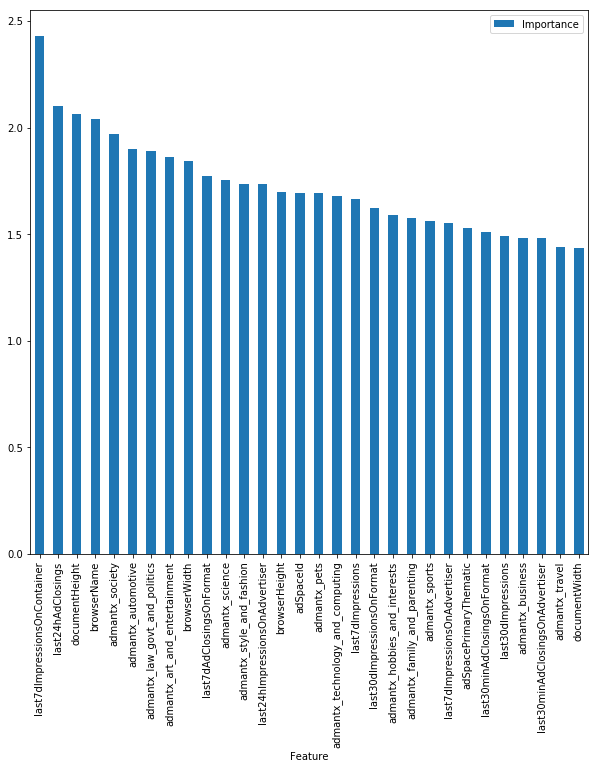

In [75]:
importances_conversion = xgb_conversion.get_score(importance_type='gain')
importance_frame_conversion = pd.DataFrame({'Importance': list(importances_conversion.values()),
                                 'Feature': list(importances_conversion.keys())})
importance_frame_conversion = importance_frame_conversion.sort_values(by = 'Importance', ascending=False).head(30)
importance_frame_conversion.plot(kind = 'bar', x = 'Feature', figsize = (10, 10))